# The goal of this Note Book
Validate the effectiveness of ResNet and its residual connections comparing the two, a regular neural network and ResNet, for CIFAR-10.

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1. Data
### 1.1 Data download

In [3]:
import urllib3
urllib3.disable_warnings()

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling cifar10-train.tfrecord...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling cifar10-test.tfrecord...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /aiffel/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [4]:
# Check the feature of dataset
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [14]:
print(f"Number of classes: {ds_info.features['label'].num_classes}")
print(f"List of classes: {ds_info.features['label'].names}")

Number of classes: 10
List of classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:
# Check the number of data
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


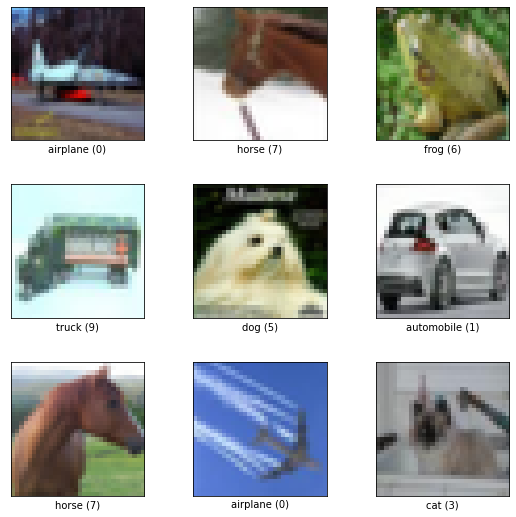

In [15]:
fig = tfds.show_examples(ds_test, ds_info)

### 1.2 Data Normalization

In [8]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

## 2. Model
### 2.1 Build VGG Blocks
VGG-16 & VGG-19

In [30]:
def build_vgg_block(input_layer, 
                    num_cnn=3, 
                    channel=64, 
                    block_num=1):
    
    x = input_layer
    
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)
        
        
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'block{block_num}_pooling'
    )(x)

    return x

In [31]:
vgg_input_layer = keras.layers.Input(shape=(224,224,3))
vgg_block_output = build_vgg_block(vgg_input_layer)

In [61]:
# VGG-16 model for CIFAR10
def build_vgg(input_shape=(224,224,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=1):
    
    #Check the config list(num_cnn, channel) before building model
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape)
    output = input_layer
    
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )
    
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(512, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(512, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='sigmoid', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    
    return model

In [62]:
vgg_16 = build_vgg()

vgg_16.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 112, 112, 64)      0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 56, 56, 128)       0  

In [63]:
vgg_19 = build_vgg(
    num_cnn_list=[2,2,4,4,4],
    channel_list=[64,128,256,512,512]
)

vgg_19.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 112, 112, 64)      0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 56, 56, 128)       0  

In [64]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
vgg_13 = build_vgg(
    num_cnn_list=[2,2,2,2,2],
    channel_list=[64,128,256,512,512]
)

vgg_13.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 112, 112, 64)      0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 56, 56, 128)       0  

### 2.2 Train Model


In [1]:
BATCH_SIZE = 256
EPOCH = 15

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

NameError: name 'tfds' is not defined

In [27]:
vgg_16.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_16 = vgg_16.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/15
195/195 [==============================] - 86s 155ms/step - loss: 2.1599 - accuracy: 0.2020 - val_loss: 2.0464 - val_accuracy: 0.2538
Epoch 2/15
195/195 [==============================] - 25s 130ms/step - loss: 1.9607 - accuracy: 0.2919 - val_loss: 1.8970 - val_accuracy: 0.3345
Epoch 3/15
195/195 [==============================] - 24s 123ms/step - loss: 1.8378 - accuracy: 0.3381 - val_loss: 1.7780 - val_accuracy: 0.3574
Epoch 4/15
195/195 [==============================] - 24s 122ms/step - loss: 1.7318 - accuracy: 0.3795 - val_loss: 1.6920 - val_accuracy: 0.3943
Epoch 5/15
195/195 [==============================] - 24s 122ms/step - loss: 1.6449 - accuracy: 0.4073 - val_loss: 1.6280 - val_accuracy: 0.4185
Epoch 6/15
195/195 [==============================] - 24s 123ms/step - loss: 1.5855 - accuracy: 0.4309 - val_loss: 1.5586 - val_accuracy: 0.4377
Epoch 7/15
195/195 [==============================] - 24s 123ms/step - loss: 1.5307 - accuracy: 0.4529 - val_loss: 1.5009 - val_ac

In [28]:
vgg_19.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_19 = vgg_19.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
195/195 [==============================] - 33s 144ms/step - loss: 2.2640 - accuracy: 0.1624 - val_loss: 2.1865 - val_accuracy: 0.1586
Epoch 2/15
195/195 [==============================] - 28s 142ms/step - loss: 2.0810 - accuracy: 0.2318 - val_loss: 2.0031 - val_accuracy: 0.2765
Epoch 3/15
195/195 [==============================] - 28s 143ms/step - loss: 1.9369 - accuracy: 0.2910 - val_loss: 1.8774 - val_accuracy: 0.3236
Epoch 4/15
195/195 [==============================] - 28s 143ms/step - loss: 1.8129 - accuracy: 0.3404 - val_loss: 1.7848 - val_accuracy: 0.3547
Epoch 5/15
195/195 [==============================] - 28s 143ms/step - loss: 1.7143 - accuracy: 0.3745 - val_loss: 1.6810 - val_accuracy: 0.3817
Epoch 6/15
195/195 [==============================] - 28s 143ms/step - loss: 1.6463 - accuracy: 0.4059 - val_loss: 1.5807 - val_accuracy: 0.4173
Epoch 7/15
195/195 [==============================] - 28s 143ms/step - loss: 1.5918 - accuracy: 0.4216 - val_loss: 1.5703 - val_ac

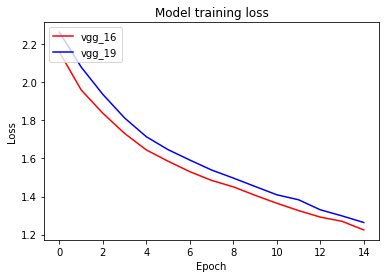

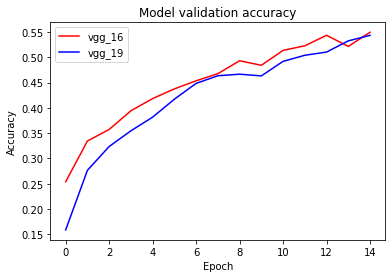

In [29]:
import matplotlib.pyplot as plt

plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

plt.plot(history_16.history['val_accuracy'], 'r')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

* Featuers we have to notice  
    - Deeper network (vgg_19) degrades rapidly  
    - Adding more layers to a suitably deep model leads to lower accuracy

### 2.3 Train cat-vs-dog vgg models

In [5]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = original_dir / subset_name / category
        
        fnames = [f"{category}.{i}.jpg"
                 for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname, dst=dir / fname)
            
make_subset("train", start_index=0, end_index=8000)
make_subset("validation", start_index=8000, end_index=10000)
make_subset("test", start_index=10000, end_index=12000)

In [66]:
from tensorflow.keras.utils import image_dataset_from_directory


# Generates a tf.data.Dataset from image files in a directory.
# Read image file and transform to RGB file
# cast dt to tf.float
# Resize tensor input size
# Configure Batch size
train_dataset = image_dataset_from_directory(
    original_dir / "train",
    image_size=(224, 224),
    batch_size=16
)

test_dataset = image_dataset_from_directory(
    original_dir / "test",
    image_size=(224, 224),
    batch_size=16
)

validation_dataset = image_dataset_from_directory(
    original_dir / "validation",
    image_size=(224, 224),
    batch_size=16
)

train_dataset = train_dataset.map(lambda x, y: (x / 255, y))
test_dataset = test_dataset.map(lambda x, y: (x / 255, y))
validation_dataset = validation_dataset.map(lambda x, y: (x / 255, y))

Found 16000 files belonging to 2 classes.
Found 4000 files belonging to 2 classes.
Found 4000 files belonging to 2 classes.


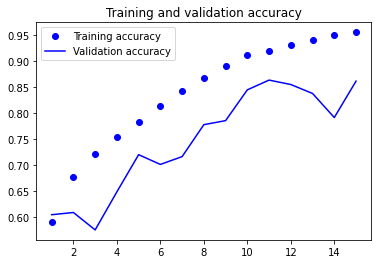

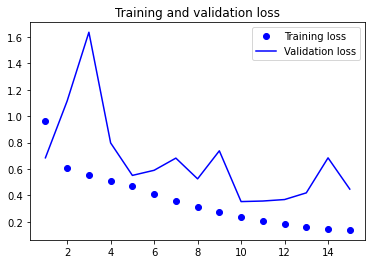

In [17]:
import json

# Load the JSON data from the file
with open("history_resnet34_dict", "r") as file:
    history_resnet34 = json.load(file)
import matplotlib.pyplot as plt



accuracy = history_resnet34["accuracy"]
val_accuracy = history_resnet34["val_accuracy"]
loss = history_resnet34["loss"]
val_loss = history_resnet34["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()


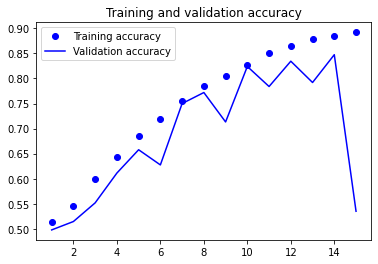

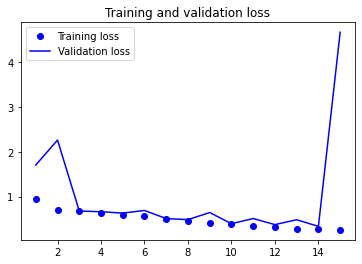

In [19]:
import json

# Load the JSON data from the file
with open("history_reg34_dict", "r") as file:
    history_reg34 = json.load(file)
import matplotlib.pyplot as plt



accuracy = history_reg34["accuracy"]
val_accuracy = history_reg34["val_accuracy"]
loss = history_reg34["loss"]
val_loss = history_reg34["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

<Figure size 432x288 with 0 Axes>

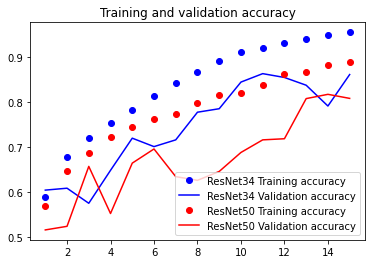

<Figure size 432x288 with 0 Axes>

In [50]:
import matplotlib.pyplot as plt
import json
# Load the JSON data from the file
with open("history_resnet34_dict", "r") as file:
    history_34 = json.load(file)
    
with open("history_resnet50_dict", "r") as file:
    history_50 = json.load(file)
import matplotlib.pyplot as plt

accuracy_34 = history_34["accuracy"]
val_accuracy_34 = history_34["val_accuracy"]
loss_34 = history_34["loss"]
val_loss_34 = history_34["val_loss"]

accuracy_50 = history_50["accuracy"]
val_accuracy_50 = history_50["val_accuracy"]
loss_50 = history_50["loss"]
val_loss_50 = history_50["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy_34, "bo", label="ResNet34 Training accuracy")
plt.plot(epochs, val_accuracy_34, "b", label="ResNet34 Validation accuracy")
plt.plot(epochs, accuracy_50, "ro", label="ResNet50 Training accuracy")
plt.plot(epochs, val_accuracy_50, "r", label="ResNet50 Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

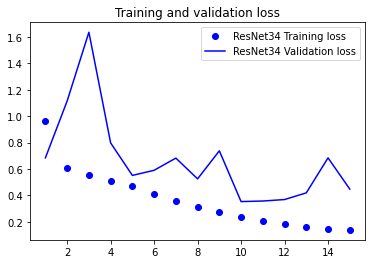

In [51]:
plt.plot(epochs, loss_34, "bo", label="ResNet34 Training loss")
plt.plot(epochs, val_loss_34, "b", label="ResNet34 Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

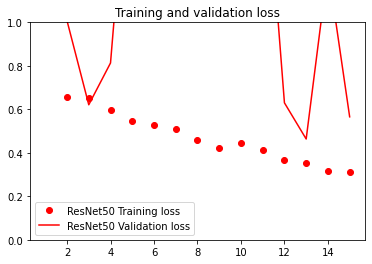

In [54]:
plt.plot(epochs, loss_50, "ro", label="ResNet50 Training loss")
plt.plot(epochs, val_loss_50, "r", label="ResNet50 Validation loss")
plt.title("Training and validation loss")
plt.legend()
# Set the y-axis limits to 0 to 5
plt.ylim(0, 1)
plt.show()

In [ ]:
# from keras.callbacks import ModelCheckpoint
vgg_16.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy'],
)
model_checkpoint = ModelCheckpoint(
    filepath="vgg_16.keras",
    save_best_only=True,
    monitor="val_loss"
)

history_vgg_16 = vgg_16.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=15,
    callbacks=model_checkpoint,
)

history_vgg_16_dict = history_vgg_16.history
# Save it under the form of a json file
json.dump(history_vgg_16_dict, open("history_vgg_16_dict", 'w'))

In [ ]:
from keras.callbacks import ModelCheckpoint
vgg_19.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy'],
)
model_checkpoint = ModelCheckpoint(
    filepath="vgg_16.keras",
    save_best_only=True,
    monitor="val_loss"
)

history_vgg_19 = vgg_19.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=15,
    callbacks=model_checkpoint,
)

history_vgg_19_dict = history_vgg_19.history
# Save it under the form of a json file
json.dump(history_vgg_16_dict, open("history_vgg_16_dict", 'w'))

Epoch 1/15
1000/1000 [==============================] - 304s 267ms/step - loss: 53856.2578 - accuracy: 0.4942 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/15
1000/1000 [==============================] - 266s 266ms/step - loss: 1.3049 - accuracy: 0.4962 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/15
1000/1000 [==============================] - 265s 265ms/step - loss: 0.9008 - accuracy: 0.4992 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/15
1000/1000 [==============================] - 266s 266ms/step - loss: 0.9635 - accuracy: 0.5002 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/15
1000/1000 [==============================] - 266s 266ms/step - loss: 0.8356 - accuracy: 0.5041 - val_loss: 0.6938 - val_accuracy: 0.5000
Epoch 6/15
1000/1000 [==============================] - 265s 264ms/step - loss: 0.7525 - accuracy: 0.5174 - val_loss: 0.6836 - val_accuracy: 0.5608
Epoch 7/15
  24/1000 [..............................] - ETA: 4:00 - loss: 0.6951 - accuracy: 0.5990